# Thomas-Fermi Solver

Now we will take a look at the Thomas-Fermi solver. This solver attempts to solve the following integral equation for the charge
density n(x):

$n(x) = \frac{g_0}{\beta}\;\text{sp}[\beta(\mu-qV(x)-{\bf K}\cdot n(x))]$

Here $g_0$ is the density of states, $\mu$ is the Fermi level, and $\beta$ is the
inverse temperature. These parameters can all be changed in the `PhysicsParameters`
dataclass. $\text{sp}(z) = \ln(1+e^z)$ is the softplus function.

In [1]:
from qdflow.physics import simulation
from qdflow import generate
import tutorial_helper
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define a set of default physical and numerical parameters
phys = generate.default_physics(n_dots=2)
phys.gates[3].peak = 7.5
x = phys.x
q = phys.q
numerics = simulation.NumericsParameters()

# Calculate V(x) and K(x, x')
V = simulation.calc_V(phys.gates, x, 0, 0)
K_mat = simulation.calc_K_mat(x, phys.K_0, phys.sigma)

Additionally, the Thomas-Fermi solver requires the following matrix in order to
help with convergence issues which we shall discuss later:

$[g_0 \delta_x {\bf K} + {\bf 1}]^{-1}$,

where $\delta_x$ is the resolution with which the x-axis has been discretized,
and ${\bf 1}$ is the identity matrix.

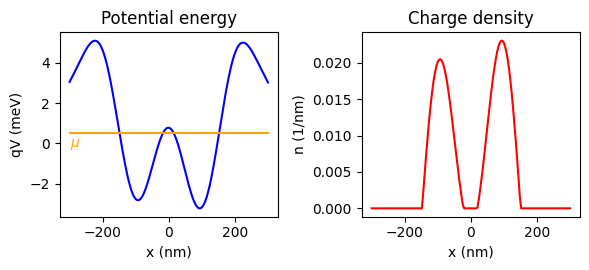

In [3]:
# Calculate the inverse of [g_0 delta_x K_mat + 1]
delta_x = x[1] - x[0]
g0_dx_K_plus_1_inv = np.linalg.inv(phys.g_0 * delta_x * K_mat + np.identity(len(x)))

# Run the Thomas-Fermi solver
# This may take a few seconds initially due to numba compilation time
n, phi, converged = simulation.ThomasFermi.calc_n(phys, numerics, V, K_mat, g0_dx_K_plus_1_inv)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(6,2.8))
tutorial_helper.plot_potential(fig, ax[0], x, q*V, mu=phys.mu)
tutorial_helper.plot_n(fig, ax[1], x, n)
ax[0].set_title("Potential energy")
ax[1].set_title("Charge density")
fig.tight_layout()


The Thomas-Fermi solver uses a successive iteration method to find n(x).
This involves starting with some "guess" $n_0(x)$ (by default zero is used),
and evaluating the integral equation above to find an updated function $n_1(x)$.

This process is then repeated until one of the following occurs:
* A maximum number of iterations is reached
* The difference $\Delta_n = n_i(x) - n_{i-1}(x)$ lies below some absolute tolerance,
satisfying $|\Delta_n| \delta_x < \text{abs\_tol}$
* $\Delta_n$ lies below some relative tolerance, satisfying
$|\Delta_n| < \text{rel\_tol} \sqrt{|n_{i-1}|*|n_i|}$

For the sake of illustration, we'll show the successive iteration method without
any additional improvements, which can be done by setting
`NumericsParameters.calc_n_use_combination_method` to False.

C:\Users\dlb8\OneDrive - NIST\Documents\qdflow_paper\QDFlow-sim\src\qdflow\physics\simulation.py:1632: ConvergenceWarning: ThomasFermi.calc_n() failed to converge.
  warnings.warn("ThomasFermi.calc_n() failed to converge.",


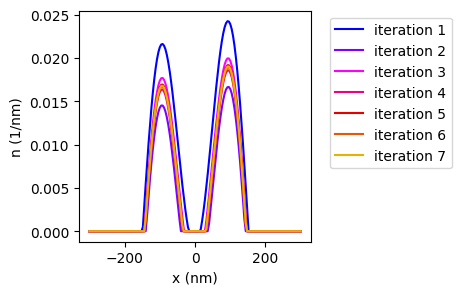

In [4]:
# Use physics parameters with a somewhat larger K_0
phys_high_K = generate.default_physics(n_dots=2)
phys_high_K.K_0 = 30
phys_high_K.gates[3].peak = 7.5
x = phys_high_K.x
q = phys_high_K.q

# Set numerics parameters to use basic method only
# and to run for the full number of iterations
numerics_basic = simulation.NumericsParameters()
numerics_basic.calc_n_use_combination_method = False
numerics_basic.calc_n_abs_tol = 0
numerics_basic.calc_n_rel_tol = 0

V = simulation.calc_V(phys_high_K.gates, x, 0, 0)
K_mat = simulation.calc_K_mat(x, phys_high_K.K_0, phys_high_K.sigma)

# Find n(x) using a different number of iterations each time
num_iterations = 7
n_result = np.zeros((num_iterations, len(x)))
for i in range(num_iterations):
    numerics_basic.calc_n_max_iterations_no_guess = i + 1
    n, phi, converged = simulation.ThomasFermi.calc_n(phys_high_K, numerics_basic, V, K_mat, None)
    n_result[i,:] = n

# Plot the results
fig, ax = plt.subplots(figsize=(3, 3))
tutorial_helper.plot_n(fig, ax, x, n_result)

Here we see the function n(x) oscillating around for a bit before converging to
the center.

Note that we get a `ConvergenceWarning`. This is because we have intentially set
the maximum number of iterations to be small so that we can track the convergence
of the method.

Now let's try again with a larger value of K_0.

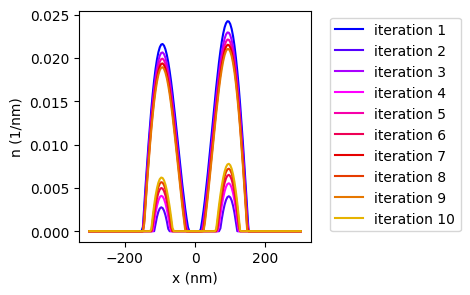

In [5]:
# Use physics parameters with a much larger K_0
phys_high_K = generate.default_physics(n_dots=2)
phys_high_K.K_0 = 80
phys_high_K.gates[3].peak = 7.5
x = phys_high_K.x
q = phys_high_K.q

# Set numerics parameters to use basic method only
# and to run for the full number of iterations
numerics_basic = simulation.NumericsParameters()
numerics_basic.calc_n_use_combination_method = False
numerics_basic.calc_n_abs_tol = 0
numerics_basic.calc_n_rel_tol = 0

V = simulation.calc_V(phys_high_K.gates, x, 0, 0)
K_mat = simulation.calc_K_mat(x, phys_high_K.K_0, phys_high_K.sigma)

# Find n(x) using a different number of iterations each time
num_iterations = 10
n_result_basic = np.zeros((num_iterations, len(x)))
for i in range(num_iterations):
    numerics_basic.calc_n_max_iterations_no_guess = i + 1
    n, phi, converged = simulation.ThomasFermi.calc_n(phys_high_K, numerics_basic, V, K_mat, None)
    n_result_basic[i,:] = n

# Plot the results
fig, ax = plt.subplots(figsize=(3, 3))
tutorial_helper.plot_n(fig, ax, x, n_result_basic)

Here n(x) appears to be oscillating between 2 values and converging very slowly,
if at all. In general, as K_0 gets larger, convergence becomes more problematic.

We can help out a bit by using the improved method discussed in
[arXiv:2509.13298](https://arxiv.org/abs/2509.13298).
The old method simply updates n(x) each iteration to be
the result of evaluating the integral equation
$n_1(x) = \frac{g_0}{\beta}\;\text{sp}[\beta(\mu-qV(x)-{\bf K}\cdot n_0(x))]$.
The improved method instead sets $n(x)$ to a combination of $n_1(x)$ and $n_0(x)$
each iteration as follows:

$n(x) = [g_0 \delta_x {\bf K} + {\bf 1}]^{-1} [g_0 \delta_x {\bf K} n_0(x) + n_1(x)]$.

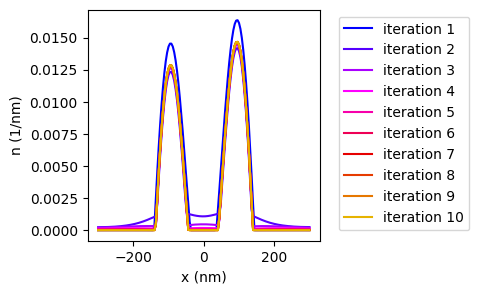

In [6]:
# Use the same example as above
phys_high_K = generate.default_physics(n_dots=2)
phys_high_K.K_0 = 80
phys_high_K.gates[3].peak = 7.5
x = phys_high_K.x
q = phys_high_K.q

# Use the default, improved method now
numerics_improved = simulation.NumericsParameters()
numerics_improved.calc_n_abs_tol = 0
numerics_improved.calc_n_rel_tol = 0

V = simulation.calc_V(phys_high_K.gates, x, 0, 0)
K_mat = simulation.calc_K_mat(x, phys_high_K.K_0, phys_high_K.sigma)

# Find n(x) using a different number of iterations each time
num_iterations = 10
n_result_improved = np.zeros((num_iterations, len(x)))
for i in range(num_iterations):
    numerics_improved.calc_n_max_iterations_no_guess = i + 1
    n, phi, converged = simulation.ThomasFermi.calc_n(phys_high_K, numerics_improved, V, K_mat, None)
    n_result_improved[i,:] = n

# Plot the results
fig, ax = plt.subplots(figsize=(3, 3))
tutorial_helper.plot_n(fig, ax, x, n_result_improved)

The improved method converges quite quickly. However, even this method has its
limits and will break down for very large $g_0 \delta_x {\bf K}$.